In [1]:
import numpy as np
import pandas as pd
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
import math

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    accuracy_score,
    precision_score,
    confusion_matrix,
)
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

from venn_abers import VennAbersCalibrator
from venn_abers_sklearn import VennAbersSKlearn

import plotly.express as px

%load_ext autoreload
%autoreload 2

In [2]:
# Load the training data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

TARGET_LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

valid_test_mask = (test_labels[TARGET_LABELS] != -1).all(axis=1)
test_data = test_data.merge(test_labels[valid_test_mask], on="id")

X_train = train_data["comment_text"]
Y_train = train_data[TARGET_LABELS]

X_test = test_data["comment_text"]
Y_test = test_data[TARGET_LABELS]

In [3]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ('clf', OneVsRestClassifier(ComplementNB()))
    ]
)

va_pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", OneVsRestClassifier(
            VennAbersSKlearn(
                estimator=ComplementNB(),
                inductive=True,
                cal_size=0.2,
                random_state=42,
            )
        ))
    ]
)

cal_pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", OneVsRestClassifier(
            CalibratedClassifierCV(
                estimator=ComplementNB(),
                method="isotonic",
                cv=3                
            ),
            n_jobs=-1
        )),
    ]
)

parameter_grid = {
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__estimator__estimator__alpha": np.logspace(-6, 1, 5),
}

In [4]:
def multilabel_macro_auc(estimator, X, y_true):
    # estimator: fitted Pipeline (vect -> OneVsRest(ComplementNB))
    y_proba = estimator.predict_proba(X)  # shape (n_samples, n_labels)
    return roc_auc_score(y_true, y_proba, average="macro")

In [5]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_splits = list(mskf.split(X_train, Y_train)) 

print("Hyperparameters to evaluate:")
pprint(parameter_grid)
print("Searching best params (macro ROC AUC)...")

search = RandomizedSearchCV(
    estimator=cal_pipeline,
    param_distributions=parameter_grid,
    n_iter=20,
    scoring=multilabel_macro_auc,
    random_state=0,
    cv=cv_splits,
    n_jobs=-1,
    verbose=1,
    refit=True,
)

t0 = time()
search.fit(X_train, Y_train)
print(f"Done in {time() - t0:.2f}s")
print("Best params:", search.best_params_)
print(f"Best CV macro AUC: {search.best_score_:.4f}")

Hyperparameters to evaluate:
{'clf__estimator__estimator__alpha': array([1.00000000e-06, 5.62341325e-05, 3.16227766e-03, 1.77827941e-01,
       1.00000000e+01]),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}
Searching best params (macro ROC AUC)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Done in 292.67s
Best params: {'vect__norm': 'l1', 'vect__ngram_range': (1, 1), 'clf__estimator__estimator__alpha': 0.0031622776601683794}
Best CV macro AUC: 0.9542


In [7]:
import pandas as pd


def shorten_param(param_name):
    """Remove components' prefixes in param_name."""
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = pd.DataFrame(search.cv_results_)
cv_results = cv_results.rename(shorten_param, axis=1)

In [8]:
import plotly.express as px

param_names = [shorten_param(name) for name in parameter_grid.keys()]
labels = {
    "mean_score_time": "CV Score time (s)",
    "mean_test_score": "CV score (AUC ROC)",
}
fig = px.scatter(
    cv_results,
    x="mean_score_time",
    y="mean_test_score",
    error_x="std_score_time",
    error_y="std_test_score",
    hover_data=param_names,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "trade-off between scoring time and mean test score",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)

In [9]:
column_results = param_names + ["mean_test_score", "mean_score_time"]

transform_funcs = dict.fromkeys(column_results, lambda x: x)
# Using a logarithmic scale for alpha
transform_funcs["alpha"] = math.log10
# L1 norms are mapped to index 1, and L2 norms to index 2
transform_funcs["norm"] = lambda x: 2 if x == "l2" else 1
# Unigrams are mapped to index 1 and bigrams to index 2
transform_funcs["ngram_range"] = lambda x: x[1]

fig = px.parallel_coordinates(
    cv_results[column_results].apply(transform_funcs),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis_r,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "Parallel coordinates plot of text classifier pipeline",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

[Calibrated]   Validation macro ROC AUC: 0.9331
[Uncalibrated] Validation macro ROC AUC: 0.9366
[Calibrated] toxic          AUC=0.9259  Acc=0.9249  Prec=0.6362
Confusion matrix:
[[56174  1714]
 [ 3092  2998]]

[Calibrated] severe_toxic   AUC=0.9489  Acc=0.9941  Prec=0.0000
Confusion matrix:
[[63603     8]
 [  367     0]]

[Calibrated] obscene        AUC=0.9297  Acc=0.9492  Prec=0.6026
Confusion matrix:
[[59433   854]
 [ 2396  1295]]

[Calibrated] threat         AUC=0.9397  Acc=0.9967  Prec=0.0000
Confusion matrix:
[[63767     0]
 [  211     0]]

[Calibrated] insult         AUC=0.9206  Acc=0.9481  Prec=0.5295
Confusion matrix:
[[59722   829]
 [ 2494   933]]

[Calibrated] identity_hate  AUC=0.9337  Acc=0.9889  Prec=0.5000
Confusion matrix:
[[63262     4]
 [  708     4]]

[Uncalibrated] toxic          AUC=0.9255  Acc=0.8716  Prec=0.4109
Confusion matrix:
[[50856  7032]
 [ 1185  4905]]

[Uncalibrated] severe_toxic   AUC=0.9544  Acc=0.9208  Prec=0.0569
Confusion matrix:
[[58606  5005]
 [   

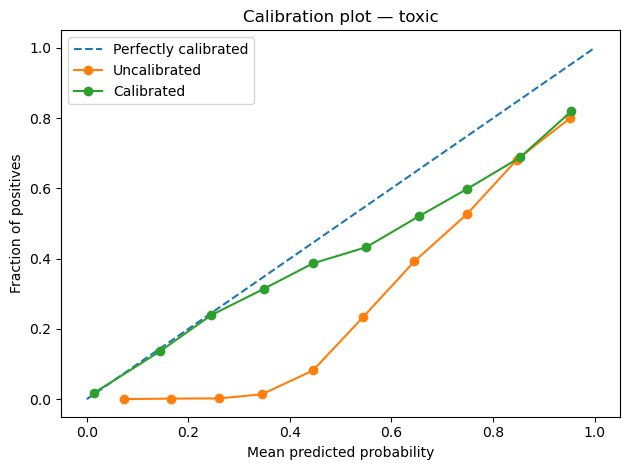

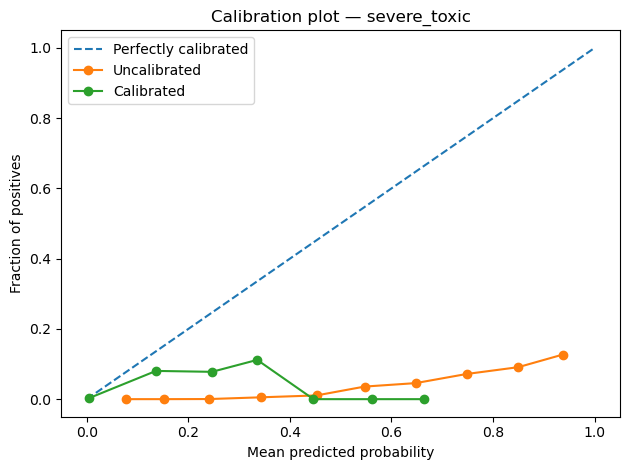

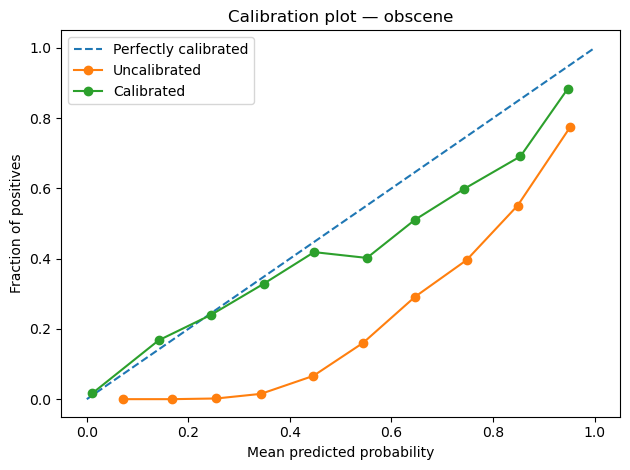

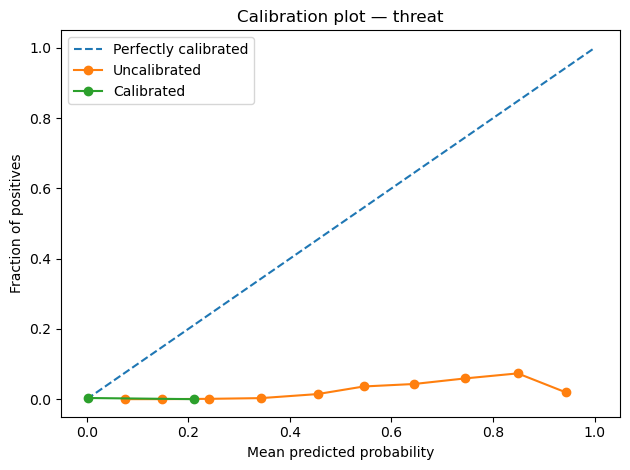

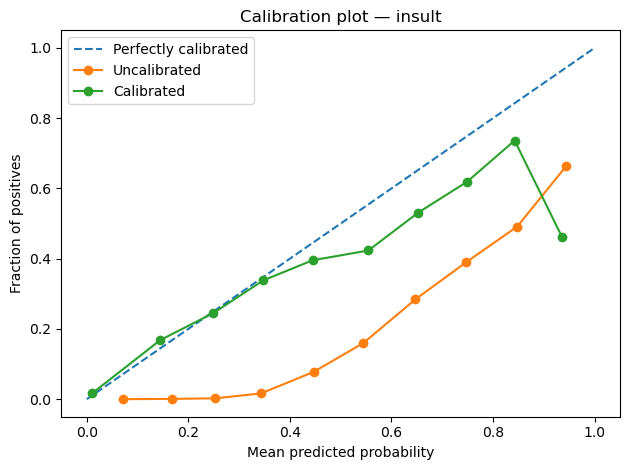

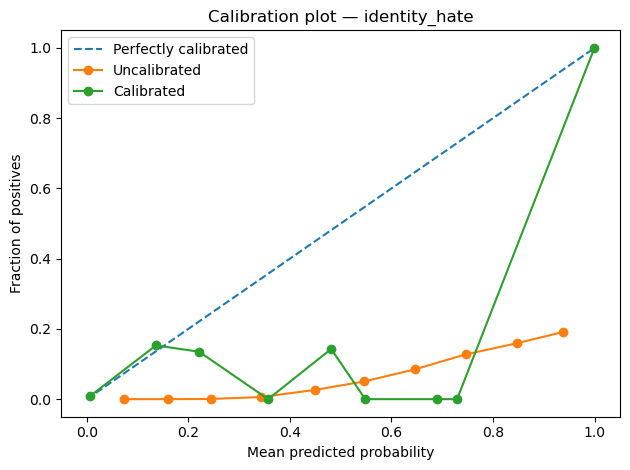

In [6]:
# --- Evaluate on validation
best_model = search.best_estimator_

# === NEW: build a FAIR uncalibrated baseline using the SAME vect params + alpha ===
baseline_model = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", OneVsRestClassifier(ComplementNB(), n_jobs=-1)),
    ]
)

# Carry over vectorizer params
best_vect_params = {k: v for k, v in search.best_params_.items() if k.startswith("vect__")}
baseline_model.set_params(**best_vect_params)

# Carry over NB alpha found inside the calibrator, if present
best_alpha = search.best_params_.get("clf__estimator__estimator__alpha", None)
if best_alpha is not None:
    baseline_model.set_params(**{"clf__estimator__alpha": best_alpha})

# Fit baseline (uncalibrated)
baseline_model.fit(X_train, Y_train)

# === Probabilities ===
Y_test_proba_cal  = best_model.predict_proba(X_test)      # calibrated
Y_test_proba_uncal = baseline_model.predict_proba(X_test) # uncalibrated

# === Threshold @ 0.5 (keep your choice; optionally tune per-label later) ===
Y_test_pred_cal   = (Y_test_proba_cal  >= 0.5).astype(int)
Y_test_pred_uncal = (Y_test_proba_uncal >= 0.5).astype(int)

# === Macro AUCs ===
macro_auc_cal   = roc_auc_score(Y_test, Y_test_proba_cal, average="macro")
macro_auc_uncal = roc_auc_score(Y_test, Y_test_proba_uncal, average="macro")
print(f"[Calibrated]   Validation macro ROC AUC: {macro_auc_cal:.4f}")
print(f"[Uncalibrated] Validation macro ROC AUC: {macro_auc_uncal:.4f}")

# === Per-label metrics ===
for i, label in enumerate(TARGET_LABELS):
    y_true = Y_test[label].values

    # Calibrated
    y_pred = Y_test_pred_cal[:, i]
    y_proba = Y_test_proba_cal[:, i]
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"[Calibrated] {label:13s}  AUC={auc:.4f}  Acc={acc:.4f}  Prec={prec:.4f}\nConfusion matrix:\n{cm}\n")

for i, label in enumerate(TARGET_LABELS):
    y_true = Y_test[label].values

    # Uncalibrated
    y_pred = Y_test_pred_uncal[:, i]
    y_proba = Y_test_proba_uncal[:, i]
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"[Uncalibrated] {label:13s}  AUC={auc:.4f}  Acc={acc:.4f}  Prec={prec:.4f}\nConfusion matrix:\n{cm}\n")

# === Reliability plots: overlay uncalibrated vs calibrated (single pass) ===
for i, label in enumerate(TARGET_LABELS):
    y_true = Y_test[label].to_numpy()
    p_unc  = Y_test_proba_uncal[:, i]
    p_cal  = Y_test_proba_cal[:, i]

    frac_unc, mean_unc = calibration_curve(y_true, p_unc, n_bins=10, strategy="uniform")
    frac_cal, mean_cal = calibration_curve(y_true, p_cal, n_bins=10, strategy="uniform")

    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
    plt.plot(mean_unc, frac_unc, marker="o", linewidth=1.5, label="Uncalibrated")
    plt.plot(mean_cal, frac_cal, marker="o", linewidth=1.5, label="Calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration plot — {label}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


In [18]:
# After fitting baseline_model or best_model
from sklearn.feature_extraction.text import TfidfVectorizer

# get vectorizer
vect = best_model.named_steps["vect"]
feature_names = np.array(vect.get_feature_names_out())

ovr = best_model.named_steps["clf"]

for i, label in enumerate(TARGET_LABELS):
    cal = ovr.estimators_[i]   # CalibratedClassifierCV
    # take one of the internal fitted base estimators (e.g. from the first fold)
    nb = cal.calibrated_classifiers_[0].estimator

    log_probs = nb.feature_log_prob_   # shape (2, n_features)
    # map back to words
    feature_names = best_model.named_steps["vect"].get_feature_names_out()
    top_idx = np.argsort(log_probs[1])[-20:][::-1]
    print(f"\nTop words for {label}:")
    for w, s in zip(feature_names[top_idx], log_probs[1][top_idx]):
        print(f"{w:20s} {s:.4f}")



Top words for toxic:
mothjer              17.2367
fack                 17.2367
cuntbag              17.2367
yourselfgo           17.2367
cocksucking          17.2367
niggas               17.2367
cocksucker           17.2367
bicth                17.2367
cunnywafts           17.2367
motherfucking        17.2367
motherfucker         17.2367
bastered             17.2367
notrhbysouthbanof    17.2367
fuk                  17.2367
buttsecks            17.2367
fuckers              17.2367
fucktard             17.2367
fuckhead             17.2367
fucksex              17.2367
chairmanofall        17.2367

Top words for severe_toxic:
fack                 17.3269
yourselfgo           17.3269
fucksex              17.3269
mothjer              17.3269
crapman              17.3269
the_real_stephen_hawkinghttp 17.3269
armarkov             17.3269
killamanjario        17.3269
fuycking             17.3269
suckersyou           17.3269
poofda               17.3269
kanuck               17.3269
cked         